# Predicts the density of other aircraft at Frankfurt Airport at the arrival time of the current aircraft

In [1]:
import pandas as pd 
from src.processing_utils.h3_preprocessing import get_h3_index
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
arrivals2022 = pd.read_csv('../../data/arrivals_2022.csv')

In [3]:
arrivals2022.sort_values(by='arrival_time', inplace = True)
arrivals2022.reset_index(inplace=True, drop=True)
arrivals2022.rename(columns={'arrival_time': 'timestamp'}, inplace=True)

In [4]:
arrivals_h3 = get_h3_index(arrivals2022, 10)

2023-10-11 19:29:00,632 [INFO]: Starting H3 preprocessing...
Processing: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
2023-10-11 19:29:06,194 [INFO]: H3 Features Added


In [7]:
arrivals_h3['general_frankfurt_density'] = 0 
for index, row in arrivals_h3.iterrows():
    density = arrivals_h3[(arrivals_h3['timestamp'] >= row['timestamp'] - pd.Timedelta(minutes=20)) &
                          (arrivals_h3['timestamp'] <= row['timestamp'])].shape[0] - 1
    arrivals_h3.at[index, 'at_frankfurt_density'] = density

In [8]:
features = ['holiday', 
            'sec_sin', 'sec_cos', 
            'day_sin', 'day_cos', 
            'weekday_0', 'weekday_1', 'weekday_2',
            'weekday_3', 'weekday_4', 'weekday_5', 
            'weekday_6']

X = arrivals_h3[features]
y = arrivals_h3['at_frankfurt_density']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Mean Squared Error: 3.1502131586638393
Mean Absolute Error: 1.3863183415225162


In [12]:
april2022 = pd.read_csv('../../data/2022/pre_processed_april2022.csv')

C:\Users\saran\AppData\Local\Temp\ipykernel_14440\2567144223.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  april2022 = pd.read_csv('../../data/2022/pre_processed_april2022.csv')


In [13]:
X_test_2 = april2022[features]

In [14]:
X_test_2

,holiday,sec_sin,sec_cos,day_sin,day_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0.903210,0.429198,0.999991,0.004304,0,0,0,0,1,0,0
1,0,0.903398,0.428804,0.999991,0.004304,0,0,0,0,1,0,0
2,0,0.903522,0.428541,0.999991,0.004304,0,0,0,0,1,0,0
3,0,0.903740,0.428081,0.999991,0.004304,0,0,0,0,1,0,0
4,0,0.904020,0.427489,0.999991,0.004304,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6280217,0,-0.510418,-0.859927,0.924291,-0.381689,0,0,0,0,0,0,1
6280218,0,-0.510605,-0.859815,0.924291,-0.381689,0,0,0,0,0,0,1
6280219,0,-0.510668,-0.859778,0.924291,-0.381689,0,0,0,0,0,0,1
6280220,0,-0.511043,-0.859555,0.924291,-0.381689,0,0,0,0,0,0,1


In [15]:
y_pred = model.predict(april2022[features])

In [16]:
april2022['at_frankfurt_density'] = y_pred

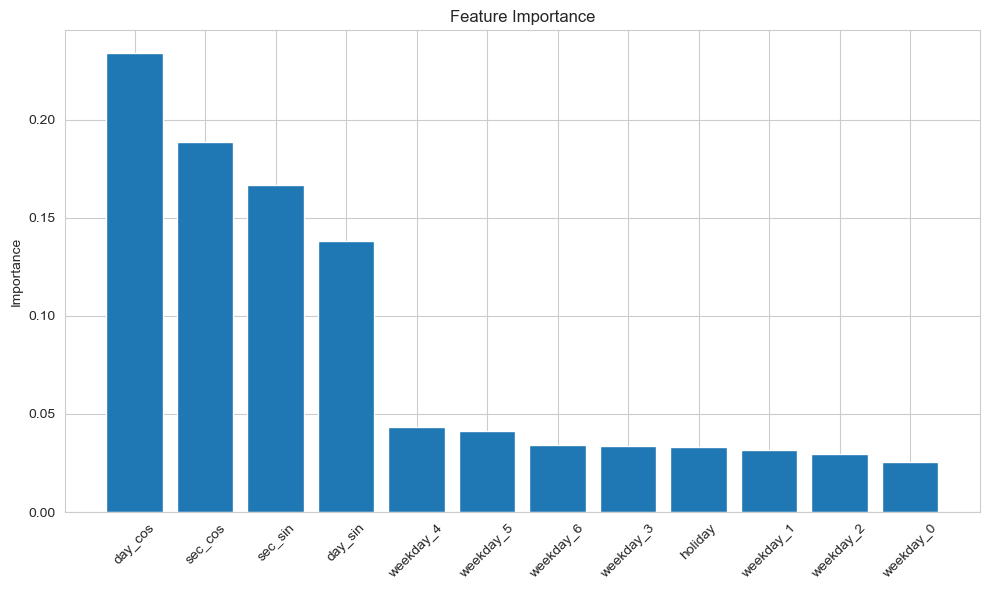

In [17]:
importances = model.feature_importances_
feature_names = features
indices = importances.argsort()[::-1]
names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])

plt.xticks(range(X_train.shape[1]), names, rotation=45)
plt.ylabel("Importance")

plt.tight_layout()
plt.show()